In [2]:
import os, sys
import socket
from random import random
from operator import add
from pyspark.sql import SparkSession

sparkSession = SparkSession.builder \
    .appName("spark-k8s-datalake") \
    .config("spark.executor.instances", "3") \
    .config('spark.driver.host', socket.gethostbyname(socket.gethostname())) \
    .getOrCreate()
sc = sparkSession.sparkContext

In [3]:
from pyspark.sql import SQLContext
import pandas as pd
import dateutil


sqlContext = SQLContext(sc)

csv_file = "adl://xxxxxx.azuredatalakestore.net/poc/kubernetes/pp-2018.csv"

data = sqlContext.read.format("csv") \
                .option("header", "false") \
                .option("delimiter",",") \
                .load(csv_file)

pdData = data.toPandas()
pdData.columns = ["TID","Price","Sale Date", "Postcode",
                                    "Property Type","New Build","Tenure",
                                    "PAON","SAON","Street","Locality",
                                    "Town/City","District","County",
                                    "PPD Category","Record Status"]
pdData['Sale Date'] = pdData['Sale Date'].apply(dateutil.parser.parse)
pdData.head()


,TID,Price,Sale Date,Postcode,Property Type,New Build,Tenure,PAON,SAON,Street,Locality,Town/City,District,County,PPD Category,Record Status
0,{79A74E21-D11E-1289-E053-6B04A8C01627},770000,2018-09-25,SK7 1AR,D,N,F,5,None,OAK MEADOW,BRAMHALL,STOCKPORT,STOCKPORT,GREATER MANCHESTER,A,A
1,{79A74E21-D11F-1289-E053-6B04A8C01627},253500,2018-09-24,M6 8GQ,D,N,F,1,None,RIVINGTON ROAD,None,SALFORD,SALFORD,GREATER MANCHESTER,A,A
2,{79A74E21-D120-1289-E053-6B04A8C01627},231950,2018-09-28,WA3 2UE,D,Y,F,35,None,STONEACRE CLOSE,LOWTON,WARRINGTON,WIGAN,GREATER MANCHESTER,A,A
3,{79A74E21-D121-1289-E053-6B04A8C01627},112500,2018-08-29,OL6 6RJ,S,N,F,102,None,THORNFIELD GROVE,None,ASHTON-UNDER-LYNE,TAMESIDE,GREATER MANCHESTER,A,A
4,{79A74E21-D122-1289-E053-6B04A8C01627},184995,2018-06-15,M46 0TW,S,Y,F,37,None,THREADNEEDLE PLACE,ATHERTON,MANCHESTER,WIGAN,GREATER MANCHESTER,A,A


In [4]:
pdData.count()

TID              181889
Price            181889
Sale Date        181889
Postcode         181059
Property Type    181889
New Build        181889
Tenure           181889
PAON             181889
SAON              23802
Street           178248
Locality          70809
Town/City        181889
District         181889
County           181889
PPD Category     181888
Record Status    181888
dtype: int64

In [5]:
pdData = pdData.loc[pdData['Record Status'] == 'A']
pdData = pdData.loc[pdData['Property Type'] != 'O']

# Select transactions for August 2018
pdData = pdData[(pdData["Sale Date"].dt.year==2018) & (pdData["Sale Date"].dt.month==8)]

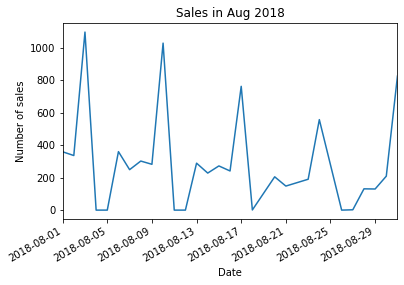

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

daily_sales_vol = pdData["Sale Date"].value_counts()
daily_sales_vol.plot()
plt.title('Sales in Aug 2018')
plt.ylabel('Number of sales')
plt.xlabel('Date')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

Text(0.5, 0, 'Date')

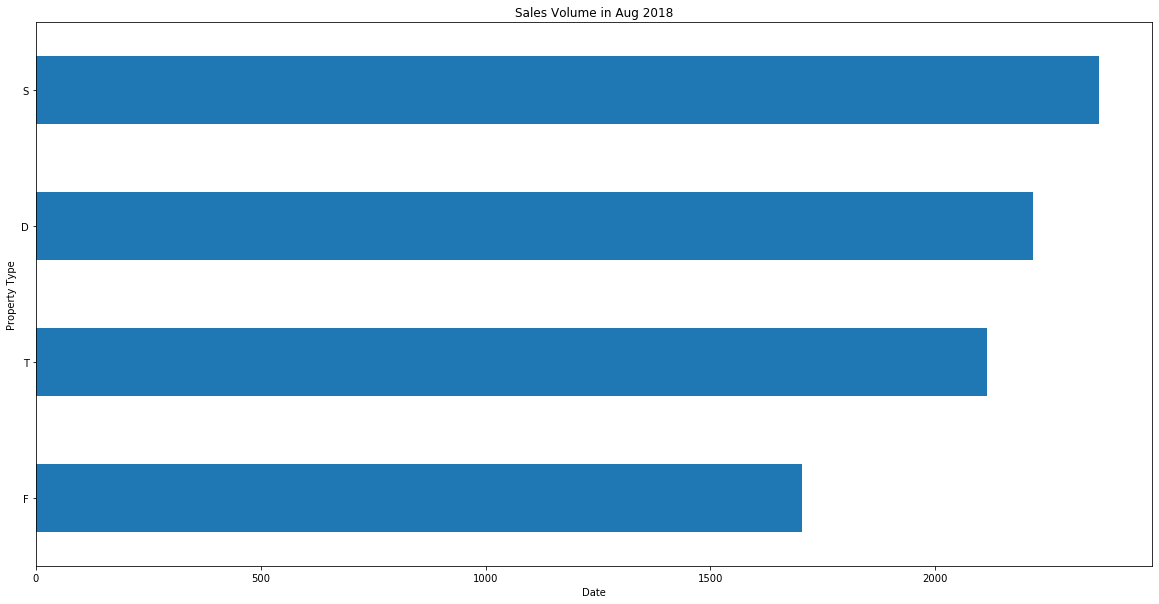

In [7]:
sales_by_type = pdData["Property Type"].value_counts()
sales_by_type.sort_values().plot(kind='barh')
plt.title('Sales Volume in Aug 2018')
plt.ylabel('Property Type')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

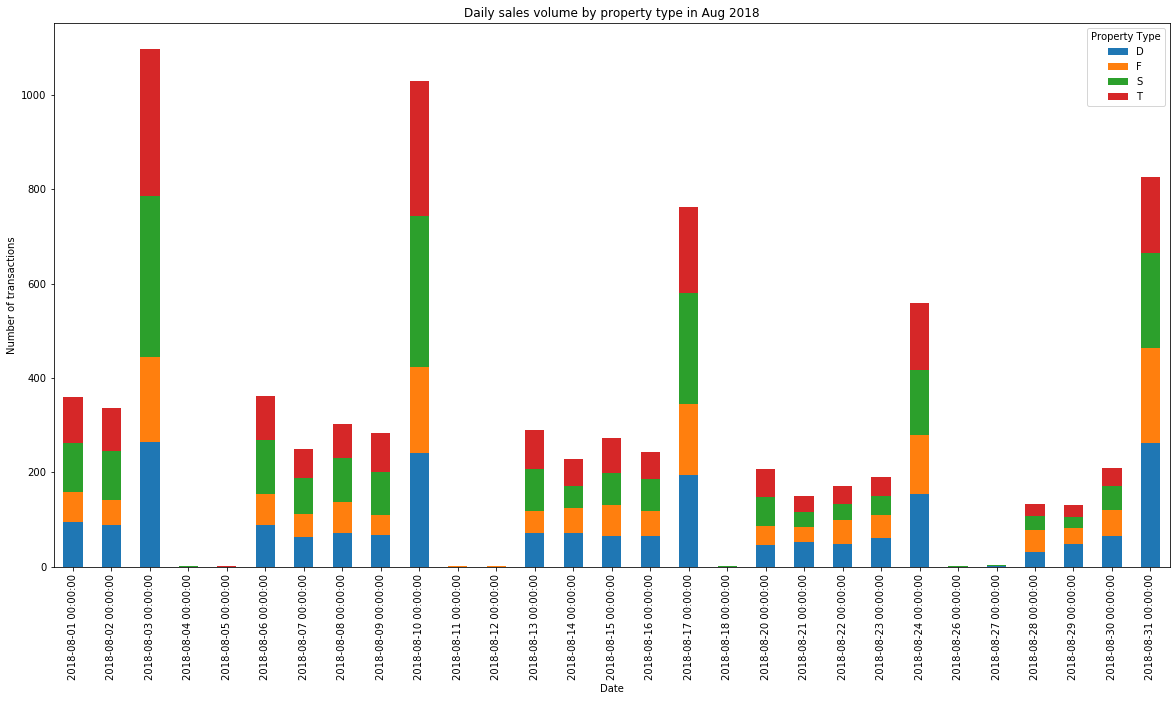

In [8]:
pdData.groupby(['Sale Date','Property Type']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Daily sales volume by property type in Aug 2018')
plt.ylabel('Number of transactions')
plt.xlabel('Date')

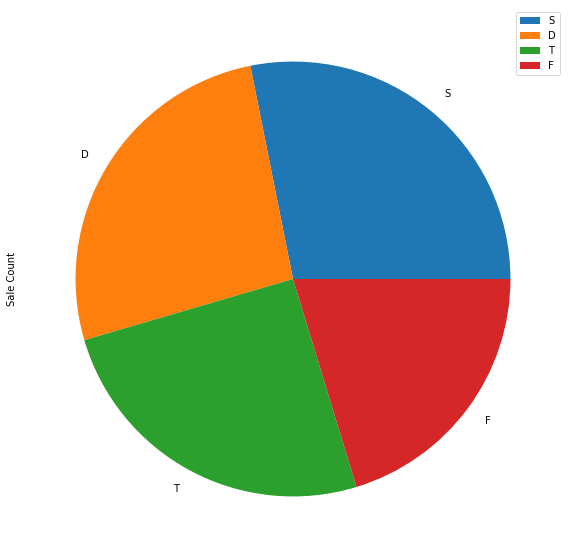

In [9]:
sale_volume = pd.DataFrame(pdData['Property Type'].value_counts())
sale_volume.columns=['Sale Count']
sale_volume.plot(kind='pie', y='Sale Count')

In [12]:
sc.stop()